### Import des images en noir et blanc

In [2]:
# Import des librairies
from PIL import Image
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Sequential, Model
from keras import applications
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
from scipy import spatial
import pathlib
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt


Using TensorFlow backend.


In [3]:
# Import des images en 240 par 240 et noir et blanc
data_dir = pathlib.Path("DATA")
image_count = len(list(data_dir.glob('*/*')))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]) 
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # redimension des images
BATCH_SIZE = image_count
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     color_mode='grayscale', # Transformation des images en noir et blanc
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 988 images belonging to 10 classes.


In [4]:
# Séparation images / labels
image_batch, label_batch = next(train_data_gen)

In [5]:
print(image_batch.shape)# Les données sont sur quatres dimensions

(988, 224, 224, 1)


In [6]:
data=image_batch.reshape(988,224*224) # On les veut sur une dimension : On a 988 images qui 
# correspondent chacunes à un vecteur de 50176 pixels
data.shape

(988, 50176)

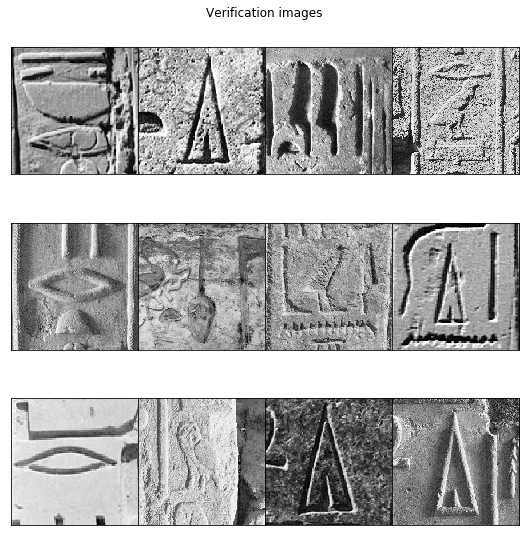

In [7]:
# définition d'une fonction d'affichage
def plot_images(images, title='', n_row=3, n_col=4, shuffle=True):
    
    """
    Affiche une série d'images
    Auteur : Antoine Likius
    """
    
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row+0.5))
    plt.suptitle(title)
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.95, hspace=0, wspace=0)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((224, 224)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    
# Affichons les premières images pour vérifier 
plot_images(data, 'Verification images')     

### ACP sur images en noir et blanc

In [8]:
# On telecharge le package scikit learn :
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

t = data

# On créer l'objet PCA :
t = StandardScaler().fit_transform(t)
comp= 300 # Choix du nombre de dimensions
pca = PCA(n_components=comp) 

# On entraine l'ACP sur les données
pca.fit(t);

# Calculez la transformée des images par ACP
data_pca = pca.transform(t) # Nous devrions dorénavant n'avoir plus que deux dimensions pour chaque image

In [9]:
data_pca.shape # On a plus que 300 dimensions par images 

(988, 300)

#### Choix du nombre de dimensions à conserver

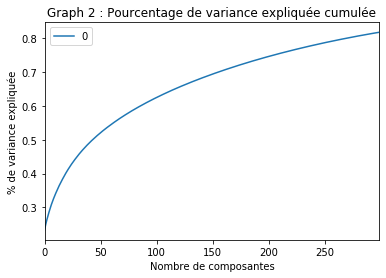

In [10]:
import pandas
pandas.DataFrame(pca.explained_variance_ratio_.cumsum()).plot() # Graph avec 200 dimensions
plt.title('Graph 2 : Pourcentage de variance expliquée cumulée')
plt.ylabel('% de variance expliquée')
plt.xlabel('Nombre de composantes')
plt.show() 

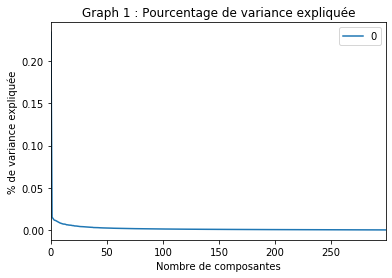

In [11]:
pandas.DataFrame(pca.explained_variance_ratio_).plot() # Graph avec 200 dimensions
plt.title('Graph 1 : Pourcentage de variance expliquée')
plt.ylabel('% de variance expliquée')
plt.xlabel('Nombre de composantes')
plt.show()

In [12]:
# On refait l'ACP avec un nombre de dimensions plus petit !
t = data
t = StandardScaler().fit_transform(t)
comp= 20 # Choix du nombre de dimensions
pca = PCA(n_components=comp) 
pca.fit(t);
ACP = pca.transform(t) # ACP correspond aux données transformées

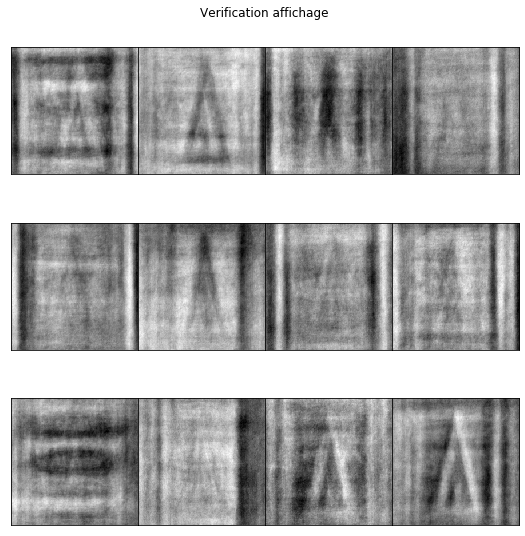

In [13]:
#reconstruction des images 
reconstruction = pca.inverse_transform(ACP)
reconstruction

plot_images(reconstruction, 'Verification affichage') 

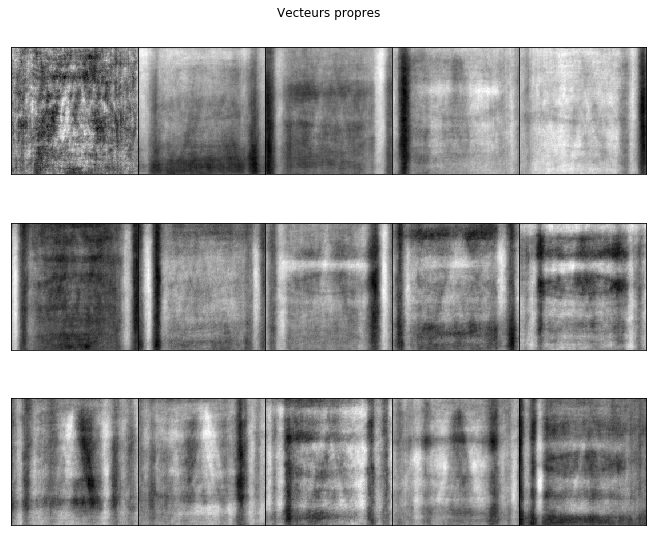

In [15]:
# Vecteurs propres / eigen faces
plot_images(pca.components_, 'Vecteurs propres',n_row=3, n_col=5)

### KNN sur les images transformées par l'ACP

In [16]:
# Split train et test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(ACP, label_batch, test_size = 0.2, random_state=42) 

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)

# Entraine le classifieur sur les données d'apprentissage
knn.fit(X_train, y_train)

# Affiche l'accuracy du modèle testé sur les données de test
print(knn.score(X_test, y_test))

0.12121212121212122


In [18]:
print('Accuracy pour chaque nombre de voisins k :')
i = 1
while i < 10:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    print("k=",i," ",knn.score(X_test, y_test))
    i = i +1

Accuracy pour chaque nombre de voisins k :
k= 1   0.30303030303030304
k= 2   0.11616161616161616
k= 3   0.18686868686868688
k= 4   0.08585858585858586
k= 5   0.15151515151515152
k= 6   0.08080808080808081
k= 7   0.12121212121212122
k= 8   0.06060606060606061
k= 9   0.0707070707070707


In [19]:
# Test avec de la cross validation 

import numpy as np
from sklearn.model_selection import cross_val_score # ou from sklearn.cross_validation import cross_val_score
k=6
knn = KNeighborsClassifier(n_neighbors=k)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy') # cv=10 demande une validation à 10 plis
print(scores)
print("Accuracy moyenne ", np.mean(scores))

[0.06329114 0.10126582 0.02531646 0.06329114 0.10126582 0.06329114
 0.05063291 0.06329114 0.10126582 0.06329114]
Accuracy moyenne  0.06962025316455696


### CONCLUSION : Nous avons besoin d'un réseau de neurones !!